# Libraries

In [78]:
%load_ext autoreload
%autoreload 2

import numpy as np
from omegaconf import OmegaConf
from src.models import models
from src.models import model as mainmodel
from src.models import modelConv2d
from src.models import modelineal
from src import loss_func
from src import train
from src import loader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from src import optimizer_Factory as of
import Data.genData as genData
from src import custom_plots as cp
from src import Visual_utils as vu
import torchvision
import wandb
import random
import os


os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:2000"
torch.cuda.empty_cache() 
torch.manual_seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Pendulum

### Load Data

In [92]:
a = genData.generateDynamics()

train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a,type="Motion")

### Visualizations

In [112]:
genData.generateVideo(a,DynamicsType = "Motion", name = "Pendulum_Original_video")

2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50, 50, 3)
2
(50,

Batch shape: torch.Size([32, 3, 50, 50])
torch.Size([3, 50, 50])
torch.Size([1, 50, 50])


/var/folders/wk/_mh2wz7s0zn4v3ldz4ml80s00000gq/T/ipykernel_58685/296776735.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greys_r', 256)
/var/folders/wk/_mh2wz7s0zn4v3ldz4ml80s00000gq/T/ipykernel_58685/296776735.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greys_r', 256)


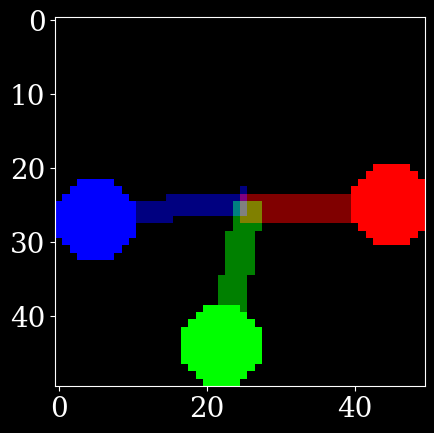

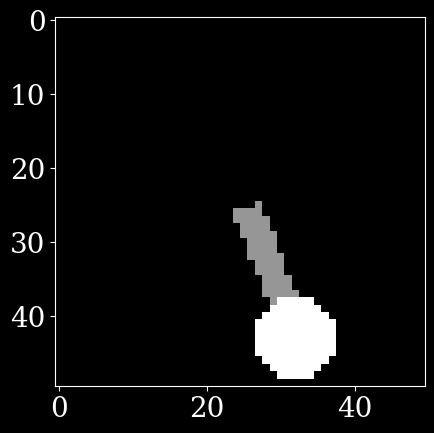

In [100]:
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a, type="Motion")

data_iter = iter(train_dataloader)

# Get a batch of data
batch_data = next(data_iter)


# Get the shape of the batch
batch_shape = batch_data[0].shape

print("Batch shape:", batch_shape)

testimage = batch_data[0][0,:,:,:]
cmap = plt.cm.get_cmap('Greys_r', 256)

print(testimage.shape)

# set gray colormap imshow
plt.figure()
plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')

testimage = batch_data[1][0,:,:,:]
cmap = plt.cm.get_cmap('Greys_r', 256)

print(testimage.shape)

# set gray colormap imshow
plt.figure()
plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')


### Model 

In [11]:

#train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a)
modelAE = models.AE(dt=1/30, initw=True)
modelAE, train_losses, val_losses, accuracy_list  = train.train(modelAE, train_dataloader, test_dataloader, 'GNNSimple')

IndexError: list index out of range

In [13]:
visual_loader= loader.getLoader(a, type="Motion", split=False)
vu.visualize(modelAE, visual_loader, video_name = 'Conv2d_ExpVsPred.mp4')
vu.CompareLatent(modelAE, visual_loader)

NameError: name 'modelAE' is not defined

### Test Decoder

In [14]:
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a, type = "Dataset_decoder")
visual_loader= loader.getLoader(a, split=False, type = "Dataset_decoder")
linearDecoder = modelineal.Decoder(initw=True)
linearDecoder, train_losses, val_losses, accuracy_list  = train.train(linearDecoder, train_dataloader, test_dataloader, '../Results/linearDecoder', loss_name='decoder_loss')

In [31]:
vu.visualize_dec(linearDecoder, visual_loader, video_name = './Results/LinearDecoder_ExpVsPred.mp4')

Video saved as ./Results/LinearDecoder_ExpVsPred.mp4


# Intensity

In [47]:

t,a = genData.generateIntensity()
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoaderIn(a,type="Intensity", split = True, type = "Dataset3d",  dt=1/100, nInFrames = 3,sr = 10 ,  noise=False, shapeType='simple')
#print(train_x.shape)
#print(val_x.shape)
#print(len(train_dataloader))
#print(len(test_dataloader))

(1600,)
(400,)
50
12


<Figure size 640x480 with 0 Axes>

### Visuals

(2000,)


<function matplotlib.pyplot.show(close=None, block=None)>

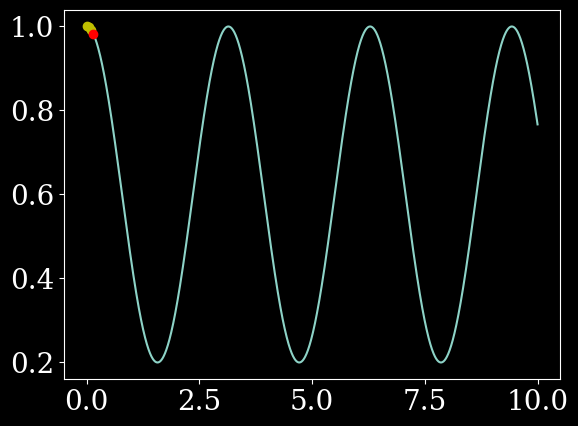

In [48]:
print(a.shape)

plt.figure()
plt.plot(t,a)
sr = 10
for i in range(4):
    if i == 3:
        plt.plot(t[i*sr],a[i*sr],'ro')
    else:
        plt.plot(t[i*sr],a[i*sr],'yo')

plt.show

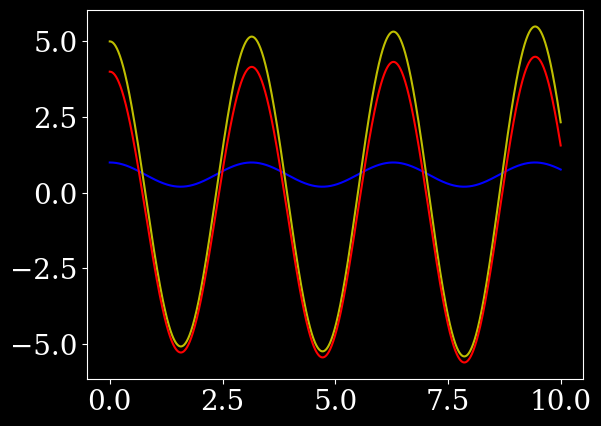

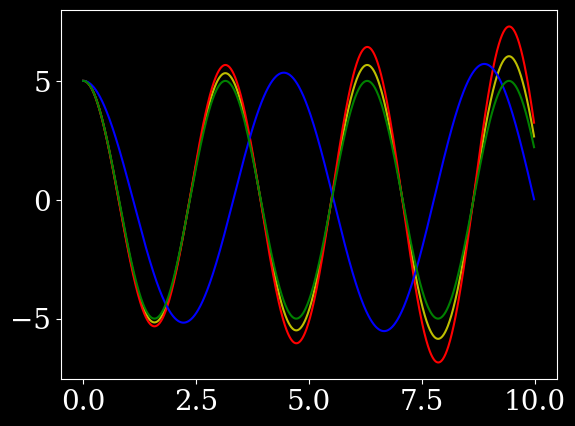

In [49]:
yd = np.zeros(2000)
yd[0]= a[0]*5
yd[1] = a[1]*5
yd[2] = a[2]*5

dt = 1/200

for i in range(2000-3):

    y0 = yd[i]
    y1 = yd[i+1]
    y2 = yd[i+2]

    yd[i+3] = y2 + (y2-y1) + dt*dt*(-4*y1)

plt.figure()
plt.plot(t,a,'b')
plt.plot(t,yd,'y')
plt.plot(t,yd-a,'r')
plt.show()

yd = np.zeros(1000)
td = np.zeros(1000)

td[0]= t[0]
td[1] = t[2]
td[2] = t[4]

yd[0]= a[0]*5
yd[1] = a[2]*5
yd[2] = a[4]*5

dt = 2/200

for i in range(1000-3):

    y0 = yd[i]
    y1 = yd[i+1]
    y2 = yd[i+2]

    yd[i+3] = y2 + (y2-y1) + dt*dt*(-4*y1)

    td[i+3] = td[i+2] + dt

plt.figure()

plt.plot(td,yd,'y')

yd = np.zeros(1000)
td = np.zeros(1000)

td[0]= t[0]
td[1] = t[2]
td[2] = t[4]

yd[0]= a[0]*5
yd[1] = a[2]*5
yd[2] = a[4]*5

dt = 2/200

for i in range(1000-3):

    y0 = yd[i]
    y1 = yd[i+1]
    y2 = yd[i+2]

    yd[i+3] = y2 + (y2-y1) + dt*dt*(-4*y0)

    td[i+3] = td[i+2] + dt
plt.plot(td,yd,'r')

yd = np.zeros(1000)
td = np.zeros(1000)

td[0]= t[0]
td[1] = t[2]
td[2] = t[4]

yd[0]= a[0]*5
yd[1] = a[2]*5
yd[2] = a[4]*5

dt = 2/200

for i in range(1000-3):

    y0 = yd[i]
    y1 = yd[i+1]
    y2 = yd[i+2]

    yd[i+3] = y2 + (y1-y0) + dt*dt*(-4*y0)

    td[i+3] = td[i+2] + dt
plt.plot(td,yd,'b')

yd = np.zeros(1000)
td = np.zeros(1000)

td[0]= t[0]
td[1] = t[2]
td[2] = t[4]

yd[0]= a[0]*5
yd[1] = a[2]*5
yd[2] = a[4]*5

dt = 2/200

for i in range(1000-3):

    y0 = yd[i]
    y1 = yd[i+1]
    y2 = yd[i+2]

    yd[i+3] = y2 + (y2-y1) + dt*dt*(-4*y2)

    td[i+3] = td[i+2] + dt
plt.plot(td,yd,'g')

plt.show()
    

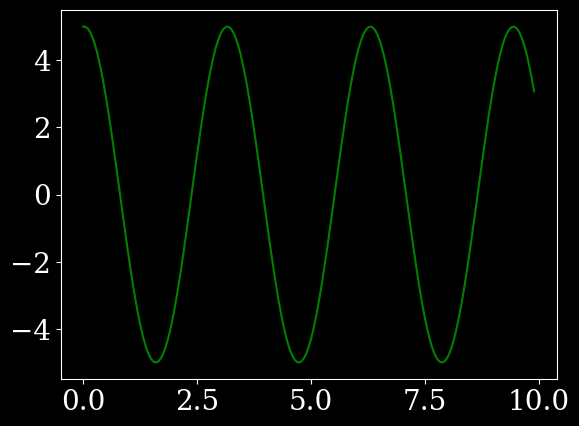

In [50]:
yd = np.zeros(200)
td = np.zeros(200)

td[0]= t[0]
td[1] = t[10]
td[2] = t[10]

yd[0]= a[0]*5
yd[1] = a[10]*5
yd[2] = a[10]*5

dt = 10/200

for i in range(200-3):

    y0 = yd[i]
    y1 = yd[i+1]
    y2 = yd[i+2]

    yd[i+3] = y2 + (y2-y1) + dt*dt*(-4*y2)

    td[i+3] = td[i+2] + dt
plt.plot(td,yd,'g')

plt.show()

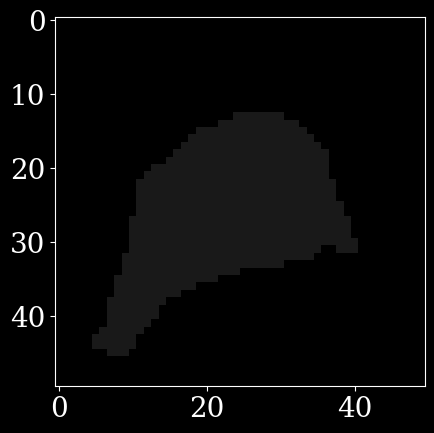

In [51]:
aa = genData.create_intensity_image(0.1, noise=False, shapeType='simple' )

plt.figure()
plt.imshow(aa, cmap='gray', vmax=1, vmin=0)


Batch shape: torch.Size([32, 3, 50, 50])
torch.Size([3, 50, 50])
torch.Size([1, 50, 50])


C:\Users\aleja\AppData\Local\Temp\ipykernel_13316\217011701.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greys_r', 256)
C:\Users\aleja\AppData\Local\Temp\ipykernel_13316\217011701.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greys_r', 256)


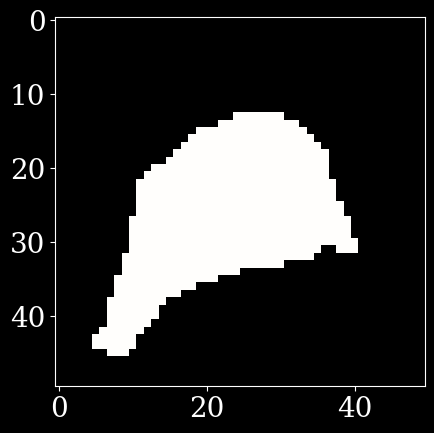

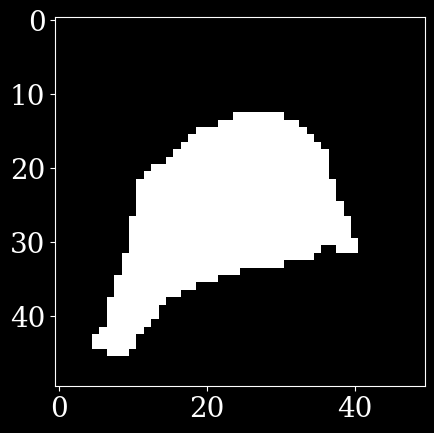

In [9]:
data_iter = iter(train_dataloader)

# Get a batch of data
batch_data = next(data_iter)


# Get the shape of the batch
batch_shape = batch_data[0].shape

print("Batch shape:", batch_shape)

testimage = batch_data[0][0,:,:,:]
cmap = plt.cm.get_cmap('Greys_r', 256)

print(testimage.shape)

# set gray colormap imshow
plt.figure()
plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')

testimage = batch_data[1][30,:,:,:]
cmap = plt.cm.get_cmap('Greys_r', 256)

print(testimage.shape)

# set gray colormap imshow
plt.figure()
plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')

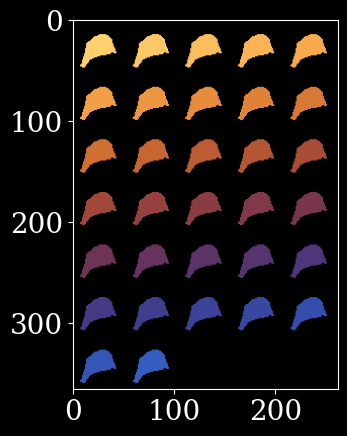

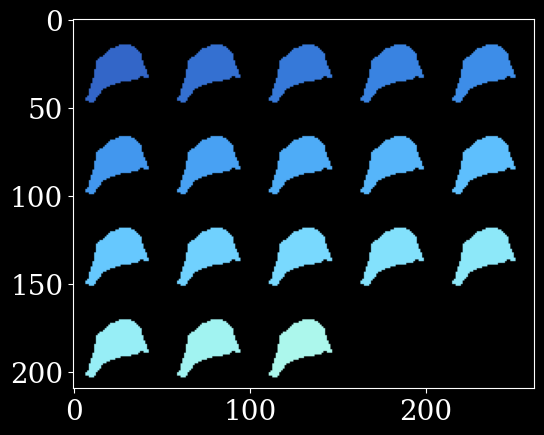

In [8]:
data_iter = iter(train_dataloader)

# Get a batch of data
batch_data = next(data_iter)

for data in train_dataloader:

    grid_img = torchvision.utils.make_grid(data[0], nrow=5)

    plt.figure()

    plt.imshow(grid_img.permute(1, 2, 0))

### Model

In [77]:


modelfull= modelineal.AE(dt=0.05, initw=True)
#modelfull= mainmodel.AEModel(dt=0.25, initw=True)#
modelfull, train_losses, val_losses, accuracy_list  = train.train(modelfull, train_dataloader, test_dataloader, 'fullmodel', type='encoder-decoder')



Using device: cpu


epoch: 10 	 training loss: 0.02393619288865011 	 validation loss: 0.27576659790550667
epoch: 20 	 training loss: 0.023681869482970797 	 validation loss: 0.11160225436712305
epoch: 30 	 training loss: 0.023644985924474896 	 validation loss: 0.07640182816733916
epoch: 40 	 training loss: 0.02363846118620131 	 validation loss: 0.06261550278092425
epoch: 50 	 training loss: 0.02367048117215745 	 validation loss: 0.057478685242434345
epoch: 60 	 training loss: 0.023703070355113594 	 validation loss: 0.05563825694844127
epoch: 70 	 training loss: 0.02370201895420905 	 validation loss: 0.05281480976069967
epoch: 80 	 training loss: 0.02352042862563394 	 validation loss: 0.047235113413383566
epoch: 90 	 training loss: 0.023520257283817046 	 validation loss: 0.04210684293260177
epoch: 100 	 training loss: 0.023377364840125665 	 validation loss: 0.0411520516499877


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


alpha,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
alpha,4.0
beta,0.0
train_loss,0.02338
validation_loss,0.04115


<Figure size 640x480 with 0 Axes>

In [55]:
for name, param in modelfull.named_parameters():
    print(name, param.shape, param.requires_grad)

print(modelfull.pModel.alpha[0])
print(modelfull.pModel.beta[0]) 

encoder.linear.0.weight torch.Size([1000, 2500]) True
encoder.linear.0.bias torch.Size([1000]) True
encoder.linear.1.weight torch.Size([500, 1000]) True
encoder.linear.1.bias torch.Size([500]) True
encoder.linear.2.weight torch.Size([1, 500]) True
encoder.linear.2.bias torch.Size([1]) True
decoder.l1.weight torch.Size([10, 1]) True
decoder.l2.weight torch.Size([1000, 10]) True
decoder.l3.weight torch.Size([2500, 1000]) True
pModel.alpha torch.Size([1]) False
pModel.beta torch.Size([1]) False
tensor(4.)
tensor(0.)


In [34]:
def phyModel(y1, y2, dt):
    alpha = 4
    return y2 + (y2-y1) - dt*dt*(alpha*y1)

print(phyModel( 0.9980, 0.9920, 0.05))

0.97602


In [74]:
visual_loader= loader.getLoaderIn(a,  split = False, type = "Dataset3d",  dt=0.05,nInFrames = 3,sr = 10 ,   noise=False, shapeType='simple')
vu.visualize(modelfull, visual_loader, video_name = 'neuronFullModel_ExpVsPred.mp4')
vu.CompareLatent(modelfull, visual_loader)

# Scale

In [108]:
t,a = genData.generateDynamics()
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a,type="Scale", split = True,  dt=1/100, nInFrames = 3,sr = 10 ,  noise=False, shapeType='simple')

<Figure size 640x480 with 0 Axes>

In [113]:
genData.generateVideo(a,DynamicsType = "Scale", name = "Scale_Original_video")

2
(50, 50, 3)


error: OpenCV(4.8.1) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::(anonymous namespace)::CvtHelper<cv::impl::(anonymous namespace)::Set<3, 4, -1>, cv::impl::(anonymous namespace)::Set<3, 4, -1>, cv::impl::(anonymous namespace)::Set<0, 2, 5>, cv::impl::(anonymous namespace)::NONE>::CvtHelper(cv::InputArray, cv::OutputArray, int) [VScn = cv::impl::(anonymous namespace)::Set<3, 4, -1>, VDcn = cv::impl::(anonymous namespace)::Set<3, 4, -1>, VDepth = cv::impl::(anonymous namespace)::Set<0, 2, 5>, sizePolicy = cv::impl::(anonymous namespace)::NONE]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


# Test

In [21]:
# Assuming batch size is 32 and images are grayscale with dimensions (height, width)
batch_size = 32
height, width = 28, 28  # Example dimensions, adjust as per your images

# Generate a random batch of images (example)
batch_images = torch.rand(batch_size, height, width)

# Reshape the batch to (batch_size, num_pixels)
batch_images_flat = batch_images.view(batch_size, -1)

print(batch_images_flat.shape)
print(batch_images.shape)

# Calculate the variance across the batch for each pixel
variances = torch.var(batch_images_flat, dim=0)

print(variances.shape)

torch.Size([32, 784])
torch.Size([32, 28, 28])
torch.Size([784])


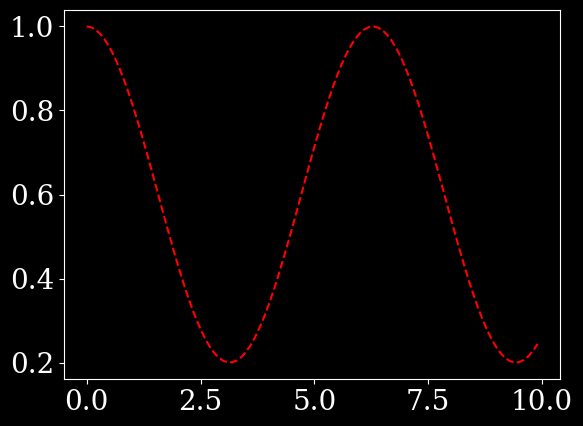

In [40]:
t = np.arange(0,10, 0.1)
m = (1-0.2)/(1-(-1))
b= 1 - m
x = m*np.cos(t)+b

y0 = x[0]
y1 = x[1]
y = np.zeros(len(t))
y[0] = y0
y[1] = y1
dt = 0.1
for i in range(2, len(t)):
    y2 = y1+ (y1-y0) -dt*dt * y1
    y[i] = y2
    y0 = y1
    y1 = y2

plt.figure()
plt.plot(t,x,'--r')
#plt.plot(t,y,'--b')
plt.show()


In [ ]:

t = np.arange(0,2*np.pi, np.pi/100)
x = np.cos(t)

y0 = x[0]
y1 = x[1]
y = np.zeros(len(t))
y[0] = y0
y[1] = y1
dt = np.pi/100
for i in range(2, len(t)):
    y2 = y1+ (y1-y0)*dt +dt*dt * y1
    y[i] = y2
    y0 = y1
    y1 = y2

plt.figure()
plt.plot(t,x,'r')
plt.plot(t,y,'b')
plt.show()